<a href="https://colab.research.google.com/github/Radomir21/Data-Analysis-2024/blob/main/Lab_3_Besh_Radomyr_Basic_Neural_Networks_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Імпорт датасету я вирішив зробити через токен на kaggle. Таким чином в майбутньому треба буде просто змінювати силку на датасет, знайдений на kaggle.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radomyrbesh","key":"3d9f9b3b5d9a12cdad820b6955786f8a"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('jsphyg/weather-dataset-rattle-package', 'Rain in Australia')


Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


In [4]:
import zipfile
path_to_zip_file = 'Rain in Australia/weather-dataset-rattle-package.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as z:
    z.extractall('Rain in Australia')

In [264]:
#бібліотеки
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import nltk
import string
from nltk import download
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from string import punctuation
import re
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import gensim

# **1) Підготовка датасету для аналізу**

In [7]:
df = pd.read_csv("/content/Rain in Australia/weatherAUS.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [8]:
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [9]:
df.isnull().sum()

,0
Date,0
Location,0
MinTemp,1485
MaxTemp,1261
Rainfall,3261
Evaporation,62790
Sunshine,69835
WindGustDir,10326
WindGustSpeed,10263
WindDir9am,10566


In [10]:
unique_values = df.apply(lambda x: x.unique())
unique_values

,0
Date,"[2008-12-01, 2008-12-02, 2008-12-03, 2008-12-0..."
Location,"[Albury, BadgerysCreek, Cobar, CoffsHarbour, M..."
MinTemp,"[13.4, 7.4, 12.9, 9.2, 17.5, 14.6, 14.3, 7.7, ..."
MaxTemp,"[22.9, 25.1, 25.7, 28.0, 32.3, 29.7, 25.0, 26...."
Rainfall,"[0.6, 0.0, 1.0, 0.2, 1.4, 2.2, 15.6, 3.6, nan,..."
Evaporation,"[nan, 12.0, 14.8, 12.6, 10.8, 11.4, 11.2, 13.0..."
Sunshine,"[nan, 12.3, 13.0, 13.3, 10.6, 12.2, 8.4, 0.0, ..."
WindGustDir,"[W, WNW, WSW, NE, NNW, N, NNE, SW, nan, ENE, S..."
WindGustSpeed,"[44.0, 46.0, 24.0, 41.0, 56.0, 50.0, 35.0, 80...."
WindDir9am,"[W, NNW, SE, ENE, SW, SSE, S, NE, nan, SSW, N,..."


In [11]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df[['RainToday','RainTomorrow']]

,RainToday,RainTomorrow
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
145455,0.0,0.0
145456,0.0,0.0
145457,0.0,0.0
145458,0.0,0.0


In [12]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df[['Date', 'Year', 'Month', 'Day']]

df.drop('Date', axis=1, inplace = True)
df.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,2008,12,5
5,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,...,1005.4,NaN,NaN,20.6,28.9,0.0,0.0,2008,12,6
6,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,...,1008.2,1.0,NaN,18.1,24.6,0.0,0.0,2008,12,7
7,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,...,1010.1,NaN,NaN,16.3,25.5,0.0,0.0,2008,12,8
8,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,...,1003.6,NaN,NaN,18.3,30.2,0.0,1.0,2008,12,9
9,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,...,1005.7,NaN,NaN,20.1,28.2,1.0,0.0,2008,12,10


In [13]:
missing_values = df.isnull().sum()
percent_missing = df.isnull().sum()/df.shape[0]*100

values = {
    'missing_values': missing_values,
    'percent_missing %': percent_missing ,
     'data type': df.dtypes
}
frame=pd.DataFrame(values)
frame

,missing_values,percent_missing %,data type
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object
WindDir3pm,4228,2.906641,object


In [14]:
df=df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am'], axis=1)
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,...,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,...,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,...,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,...,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,...,24.0,1024.6,1020.3,10.1,22.4,0.0,0.0,2017,6,21
145456,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,...,21.0,1023.5,1019.1,10.9,24.5,0.0,0.0,2017,6,22
145457,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,...,24.0,1021.0,1016.8,12.5,26.1,0.0,0.0,2017,6,23
145458,Uluru,7.8,27.0,0.0,SE,28.0,SSE,N,13.0,7.0,...,24.0,1019.4,1016.5,15.1,26.0,0.0,0.0,2017,6,24


In [15]:
missing_values = df.isnull().sum()
percent_missing = df.isnull().sum()/df.shape[0]*100

values = {
    'missing_values': missing_values,
    'percent_missing %': percent_missing ,
     'data type': df.dtypes
}
frame=pd.DataFrame(values)
frame

,missing_values,percent_missing %,data type
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object
WindDir3pm,4228,2.906641,object
WindSpeed9am,1767,1.214767,float64
WindSpeed3pm,3062,2.105046,float64


In [16]:
df.dropna(how='all', subset=['RainTomorrow'], inplace=True)
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,...,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,...,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,...,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,...,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,...,27.0,1024.7,1021.2,9.4,20.9,0.0,0.0,2017,6,20
145455,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,...,24.0,1024.6,1020.3,10.1,22.4,0.0,0.0,2017,6,21
145456,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,...,21.0,1023.5,1019.1,10.9,24.5,0.0,0.0,2017,6,22
145457,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,...,24.0,1021.0,1016.8,12.5,26.1,0.0,0.0,2017,6,23


In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns,categorical_columns

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Temp9am',
  'Temp3pm',
  'RainToday',
  'RainTomorrow',
  'Year',
  'Month',
  'Day'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [18]:
(df[categorical_columns].isnull().sum()/len(df[categorical_columns])*100)

,0
Location,0.000000
WindGustDir,6.561504
WindDir9am,7.041838
WindDir3pm,2.656952


In [19]:
df=df.drop(['Rainfall'], axis=1)
numeric_columns
numeric_columns.remove('Rainfall')

In [20]:
df.head(10)

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12,5
5,Albury,14.6,29.7,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,0.0,0.0,2008,12,6
6,Albury,14.3,25.0,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,0.0,0.0,2008,12,7
7,Albury,7.7,26.7,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,0.0,0.0,2008,12,8
8,Albury,9.7,31.9,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,0.0,1.0,2008,12,9
9,Albury,13.1,30.1,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,20.1,28.2,1.0,0.0,2008,12,10


In [21]:
median_values = df[numeric_columns].median()
df[numeric_columns] = df[numeric_columns].fillna(value=median_values)

In [23]:
df.head(10)

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12,1
1,Albury,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12,2
2,Albury,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12,3
3,Albury,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12,4
4,Albury,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12,5
5,Albury,14.6,29.7,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,0.0,0.0,2008,12,6
6,Albury,14.3,25.0,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,0.0,0.0,2008,12,7
7,Albury,7.7,26.7,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,0.0,0.0,2008,12,8
8,Albury,9.7,31.9,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,0.0,1.0,2008,12,9
9,Albury,13.1,30.1,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,20.1,28.2,1.0,0.0,2008,12,10


In [24]:
le = LabelEncoder()
df[categorical_columns] =df[categorical_columns].astype('str').apply(le.fit_transform)

In [25]:
mode_values=df[categorical_columns].mode()
df[categorical_columns] = df[categorical_columns].fillna(value=mode_values)

In [26]:
df.isnull().sum()

,0
Location,0
MinTemp,0
MaxTemp,0
WindGustDir,0
WindGustSpeed,0
WindDir9am,0
WindDir3pm,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0


In [27]:
df.head(10)

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,2,13.4,22.9,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,2008,12,1
1,2,7.4,25.1,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,2008,12,2
2,2,12.9,25.7,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,2008,12,3
3,2,9.2,28.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,2008,12,4
4,2,17.5,32.3,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,2008,12,5
5,2,14.6,29.7,14,56.0,13,13,19.0,24.0,55.0,23.0,1009.2,1005.4,20.6,28.9,0.0,0.0,2008,12,6
6,2,14.3,25.0,13,50.0,12,13,20.0,24.0,49.0,19.0,1009.6,1008.2,18.1,24.6,0.0,0.0,2008,12,7
7,2,7.7,26.7,13,35.0,10,13,6.0,17.0,48.0,19.0,1013.4,1010.1,16.3,25.5,0.0,0.0,2008,12,8
8,2,9.7,31.9,6,80.0,9,7,7.0,28.0,42.0,9.0,1008.9,1003.6,18.3,30.2,0.0,1.0,2008,12,9
9,2,13.1,30.1,13,28.0,8,10,15.0,11.0,58.0,27.0,1007.0,1005.7,20.1,28.2,1.0,0.0,2008,12,10


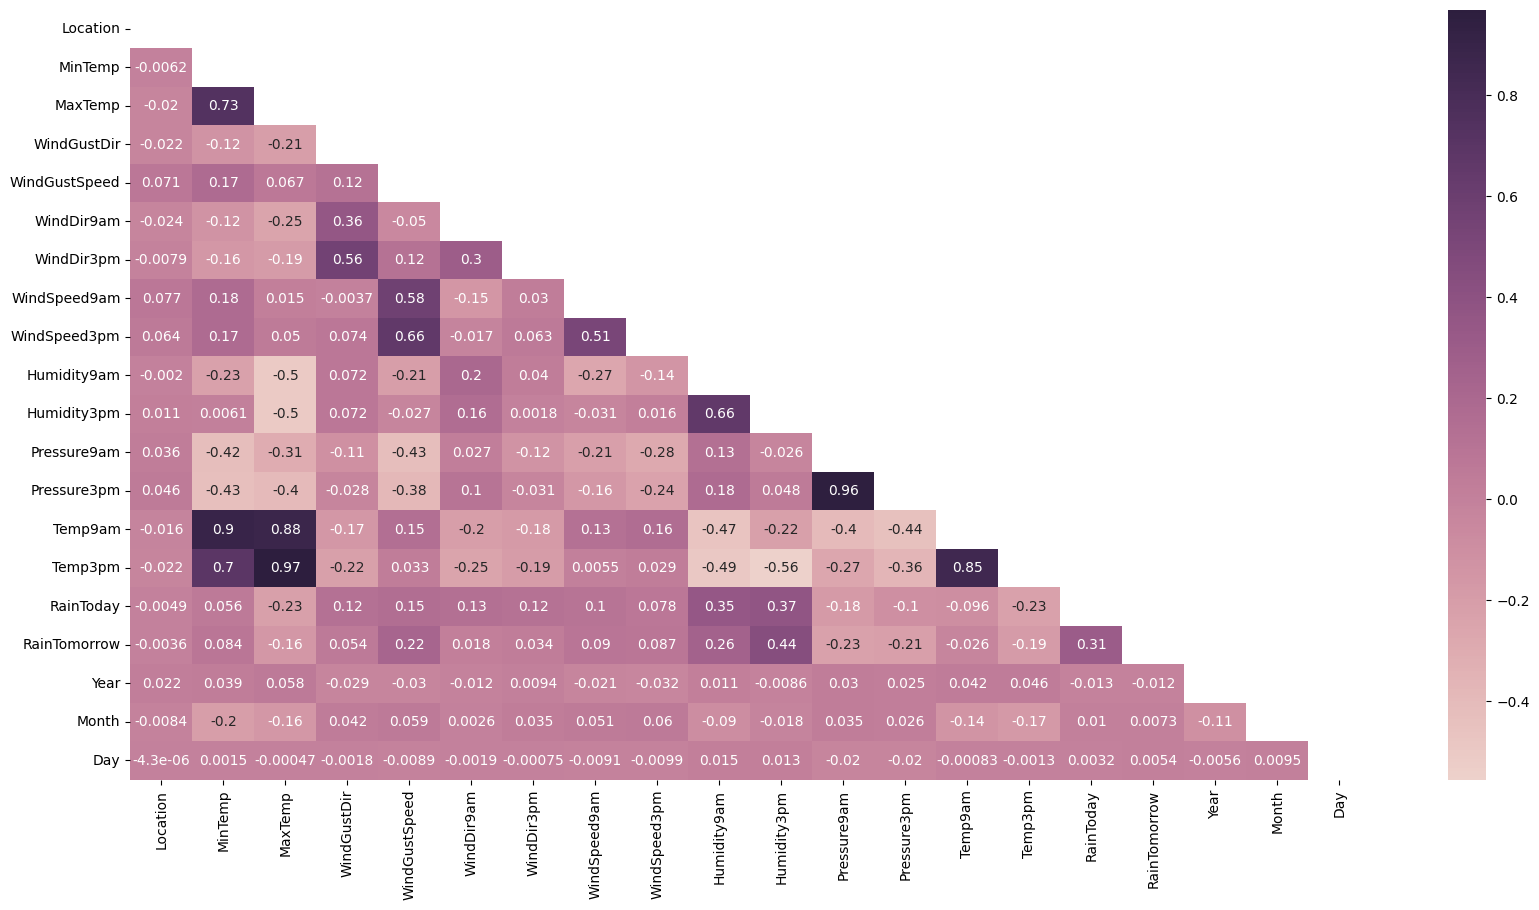

In [28]:
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot= True , cbar=True, cmap=sns.cubehelix_palette(as_cmap=True), mask=mask)
plt.show()

In [29]:
df=df.drop(columns=['Temp9am','Temp3pm','Pressure9am'],axis=1)

In [30]:
numcol_del=['temp9am','temp3pm','pressure9am']
numeric_columns = list(set(numeric_columns) - set(numcol_del))
numeric_columns

['RainToday',
 'Temp3pm',
 'Year',
 'Temp9am',
 'RainTomorrow',
 'Day',
 'WindSpeed9am',
 'MaxTemp',
 'Pressure3pm',
 'MinTemp',
 'Humidity9am',
 'Pressure9am',
 'WindGustSpeed',
 'Humidity3pm',
 'WindSpeed3pm',
 'Month']

In [31]:
df.describe()

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,Year,Month,Day
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,23.740655,12.185565,23.225365,8.255885,39.920123,7.915755,7.974471,13.992489,18.644279,68.858235,51.495742,1015.252481,0.221213,0.224181,2012.758926,6.402544,15.715084
std,14.237503,6.388936,7.109617,4.953096,13.140632,4.911307,4.731493,8.851614,8.721688,18.932512,20.532227,6.681810,0.415065,0.417043,2.541256,3.426506,8.798150
min,0.000000,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,977.100000,0.000000,0.000000,2007.000000,1.000000,1.000000
25%,11.000000,7.600000,17.900000,4.000000,31.000000,3.000000,4.000000,7.000000,13.000000,57.000000,37.000000,1011.000000,0.000000,0.000000,2011.000000,3.000000,8.000000
50%,24.000000,12.000000,22.600000,9.000000,39.000000,8.000000,8.000000,13.000000,19.000000,70.000000,52.000000,1015.200000,0.000000,0.000000,2013.000000,6.000000,16.000000
75%,36.000000,16.800000,28.200000,13.000000,46.000000,12.000000,12.000000,19.000000,24.000000,83.000000,65.000000,1019.400000,0.000000,0.000000,2015.000000,9.000000,23.000000
max,48.000000,33.900000,48.100000,16.000000,135.000000,16.000000,16.000000,130.000000,87.000000,100.000000,100.000000,1039.600000,1.000000,1.000000,2017.000000,12.000000,31.000000


In [32]:
df.head(10)

,Location,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,Year,Month,Day
0,2,13.4,22.9,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.1,0.0,0.0,2008,12,1
1,2,7.4,25.1,14,44.0,6,15,4.0,22.0,44.0,25.0,1007.8,0.0,0.0,2008,12,2
2,2,12.9,25.7,15,46.0,13,15,19.0,26.0,38.0,30.0,1008.7,0.0,0.0,2008,12,3
3,2,9.2,28.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1012.8,0.0,0.0,2008,12,4
4,2,17.5,32.3,13,41.0,1,7,7.0,20.0,82.0,33.0,1006.0,0.0,0.0,2008,12,5
5,2,14.6,29.7,14,56.0,13,13,19.0,24.0,55.0,23.0,1005.4,0.0,0.0,2008,12,6
6,2,14.3,25.0,13,50.0,12,13,20.0,24.0,49.0,19.0,1008.2,0.0,0.0,2008,12,7
7,2,7.7,26.7,13,35.0,10,13,6.0,17.0,48.0,19.0,1010.1,0.0,0.0,2008,12,8
8,2,9.7,31.9,6,80.0,9,7,7.0,28.0,42.0,9.0,1003.6,0.0,1.0,2008,12,9
9,2,13.1,30.1,13,28.0,8,10,15.0,11.0,58.0,27.0,1005.7,1.0,0.0,2008,12,10


# **2) Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network).**

In [98]:
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

In [100]:
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


y = LabelEncoder().fit_transform(y)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113754, 16), (28439, 16), (113754,), (28439,))

In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [111]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                     │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8186 - loss: 0.4169 - val_accuracy: 0.8440 - val_loss: 0.3650
Epoch 2/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8413 - loss: 0.3748 - val_accuracy: 0.8453 - val_loss: 0.3610
Epoch 3/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8446 - loss: 0.3690 - val_accuracy: 0.8447 - val_loss: 0.3599
Epoch 4/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8451 - loss: 0.3657 - val_accuracy: 0.8450 - val_loss: 0.3588
Epoch 5/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8432 - loss: 0.3672 - val_accuracy: 0.8448 - val_loss: 0.3578
Epoch 6/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8440 - loss: 0.3657 - val_accuracy: 0.8468 - val_loss: 0.3578
Epoch 7/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8448 - loss: 0.3639 - val_accuracy: 0.8429 - val_loss: 0.3596
Epoch 8/20
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8455 - loss: 0

In [114]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


889/889 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8426 - loss: 0.3589
Test Loss: 0.357067734003067, Test Accuracy: 0.8445093035697937


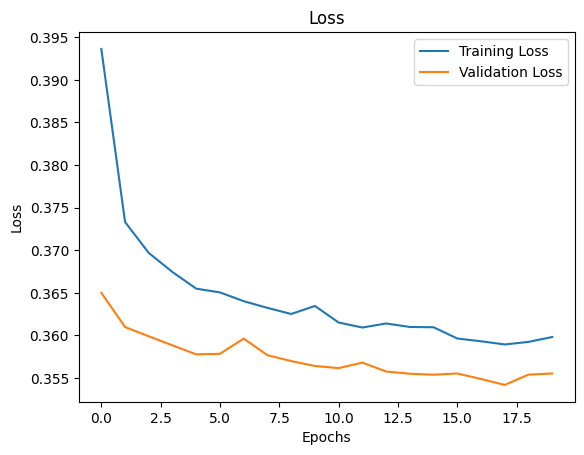

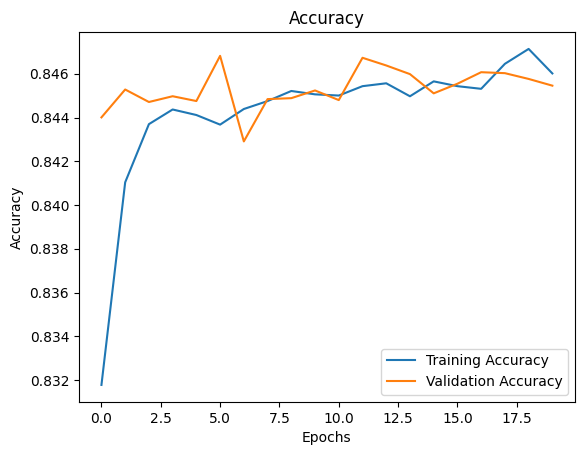

In [115]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


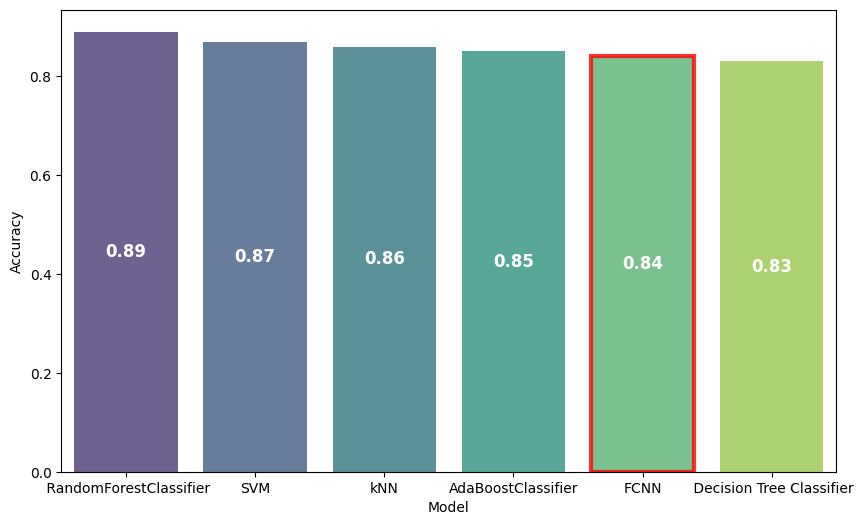

In [120]:
comparison = pd.DataFrame({'Model' : ['kNN', ' Decision Tree Classifier', 'SVM', ' RandomForestClassifier', 'AdaBoostClassifier', 'FCNN'],
                           'Accuracy' : [0.86, 0.83, 0.87 ,0.89 , 0.85, 0.84]})

comparison = comparison.sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(y = 'Accuracy', x = 'Model', hue='Model', data=comparison, palette='viridis', alpha=0.8, legend=False)

fcnn_bar = ax.patches[comparison['Model'].tolist().index('FCNN')]
fcnn_bar.set_edgecolor('red')
fcnn_bar.set_linewidth(3)

for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(f'{p.get_height():.2f}', (x, y), ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.show()


# **3) Згорткові нейронні мережі. Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі двома способами а) навчить мережу з нуля (from scratch) б) застосуйте перенесення навчання (transfer learning from pre-trained weights).Порівняйте результати (якщо в обраному датасеті класів забагато, достатньо залишити 3-5).**

In [121]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('balabaskar/tom-and-jerry-image-classification', 'Tom and Jerry Image classification')

Dataset URL: https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification


In [123]:
import zipfile
path_to_zip_file = '/content/Tom and Jerry Image classification/tom-and-jerry-image-classification.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as z:
    z.extractall('Tom and Jerry Image classification')

In [125]:
IMAGE_DIRECTORY = "/content/Tom and Jerry Image classification/tom_and_jerry/tom_and_jerry"
batch_size = 32
img_height = 72
img_width = 128

In [126]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.


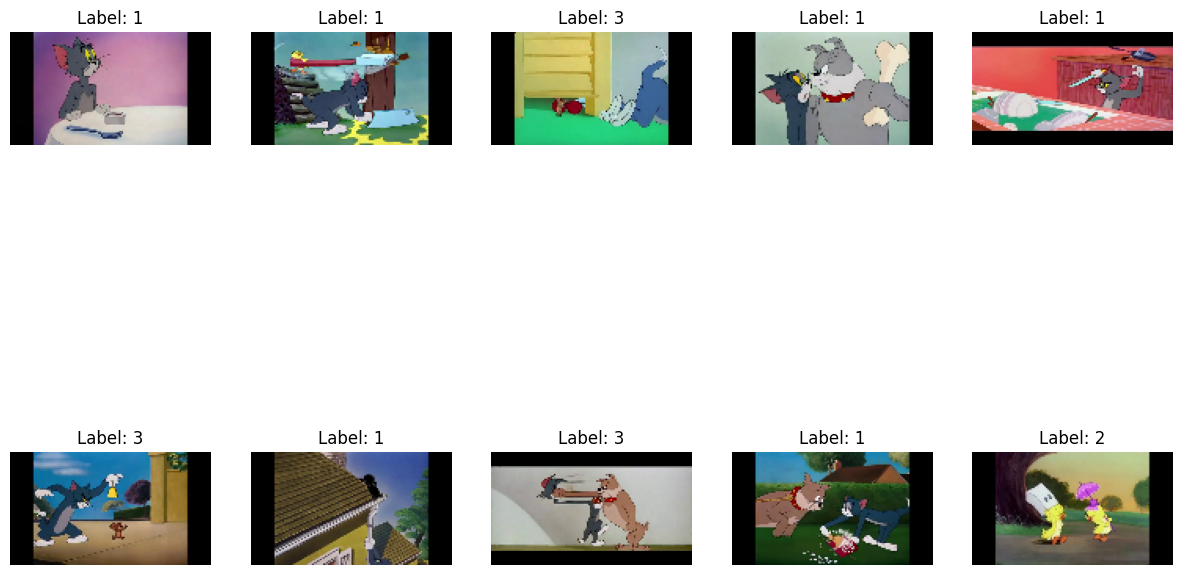

In [127]:
plt.figure(figsize=(15, 10))
for i, (images, labels) in enumerate(train_ds.take(1)):
    for j in range(10):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")
plt.show()

In [128]:
categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

In [143]:
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(categories))
])

In [144]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [145]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 86s 572ms/step - accuracy: 0.3611 - loss: 1.3396 - val_accuracy: 0.5644 - val_loss: 1.0339
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.5900 - loss: 1.0041 - val_accuracy: 0.6877 - val_loss: 0.7898
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 479ms/step - accuracy: 0.7305 - loss: 0.7139 - val_accuracy: 0.6502 - val_loss: 0.8965
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 488ms/step - accuracy: 0.7881 - loss: 0.5542 - val_accuracy: 0.7881 - val_loss: 0.5868
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 508ms/step - accuracy: 0.8600 - loss: 0.3768 - val_accuracy: 0.7708 - val_loss: 0.6209
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 475ms/step - accuracy: 0.8860 - loss: 0.3081 - val_accuracy: 0.8219 - val_loss: 0.5234
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 487ms/step - accuracy: 0.9225 - loss: 0.2121 - val_accuracy: 0.8347 - val_loss: 0.5302
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - accuracy: 0.9235 - loss: 0

In [146]:
cnn_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 72, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 128, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 36, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 18, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 16, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,611,630 (13.78 MB)

 Trainable params: 1,203,876 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,407,754 (9.18 MB)

In [150]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(72, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

<ipython-input-150-2c0fcf753f47>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(72, 128, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [151]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [154]:
history_MobileNetV2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 74s 543ms/step - accuracy: 0.8152 - loss: 0.4874 - val_accuracy: 0.6247 - val_loss: 1.1054
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 77s 507ms/step - accuracy: 0.8464 - loss: 0.4356 - val_accuracy: 0.6612 - val_loss: 0.9986
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 513ms/step - accuracy: 0.8706 - loss: 0.3745 - val_accuracy: 0.6384 - val_loss: 1.1058
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 502ms/step - accuracy: 0.8680 - loss: 0.3725 - val_accuracy: 0.6539 - val_loss: 1.0274
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 84s 517ms/step - accuracy: 0.8885 - loss: 0.3327 - val_accuracy: 0.6557 - val_loss: 1.0594
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - accuracy: 0.9124 - loss: 0.2756 - val_accuracy: 0.6557 - val_loss: 1.0952
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 61s 448ms/step - accuracy: 0.9123 - loss: 0.2637 - val_accuracy: 0.6411 - val_loss: 1.2999
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.9050 - loss: 0

In [167]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 3, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)

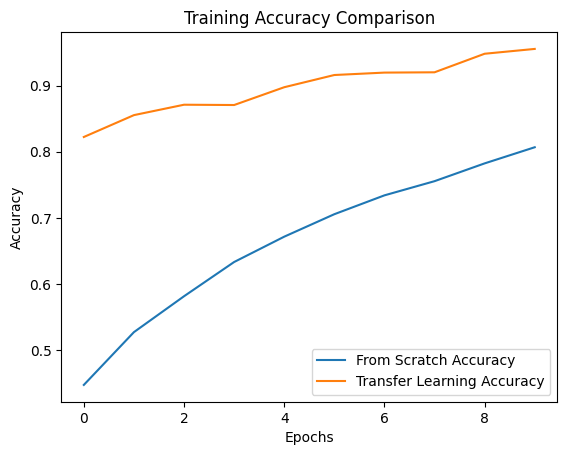

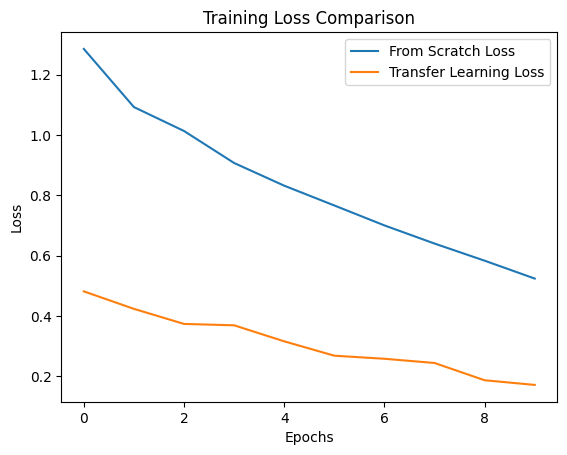

In [157]:
plt.plot(history.history['accuracy'], label='From Scratch Accuracy')
plt.plot(history_MobileNetV2.history['accuracy'], label='Transfer Learning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Comparison')
plt.show()


plt.plot(history.history['loss'], label='From Scratch Loss')
plt.plot(history_MobileNetV2.history['loss'], label='Transfer Learning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

In [158]:
cnn_score = model.evaluate(val_ds, verbose=0)

In [159]:
MobileNetV2_score = model.evaluate(val_ds, verbose=0)

In [163]:
train_acc_MobileNetV2 = history_MobileNetV2.history['accuracy']
train_loss_MobileNetV2 = history_MobileNetV2.history['loss']

val_acc_MobileNetV2 = history_MobileNetV2.history['val_accuracy']
val_loss_MobileNetV2 = history_MobileNetV2.history['val_loss']

train_acc_cnn = history.history['accuracy']
train_loss_cnn = history.history['loss']

val_acc_cnn = history.history['val_accuracy']
val_loss_cnn = history.history['val_loss']


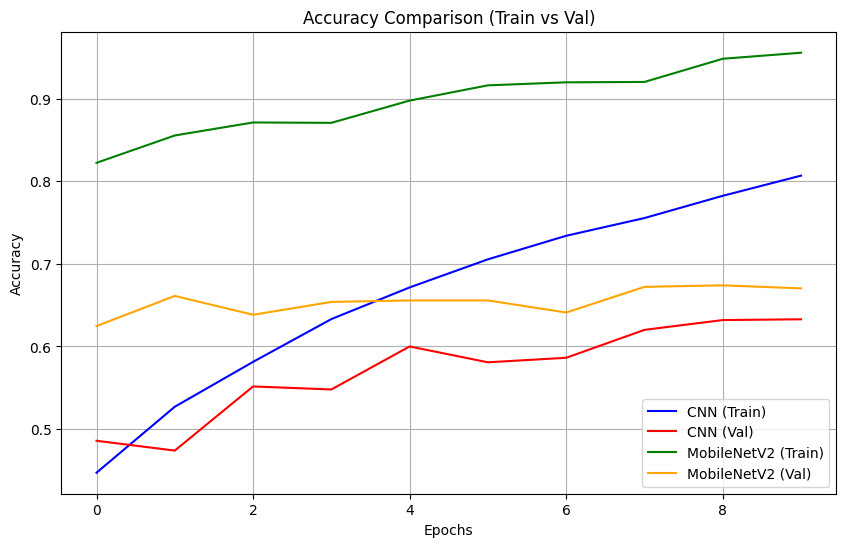

In [165]:
plt.figure(figsize=(10, 6))

plt.plot(train_acc_cnn, label='CNN (Train)', color='blue')
plt.plot(val_acc_cnn, label='CNN (Val)', color='red')

plt.plot(train_acc_MobileNetV2, label='MobileNetV2 (Train)', color='green')
plt.plot(val_acc_MobileNetV2, label='MobileNetV2 (Val)', color='orange')

plt.title('Accuracy Comparison (Train vs Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


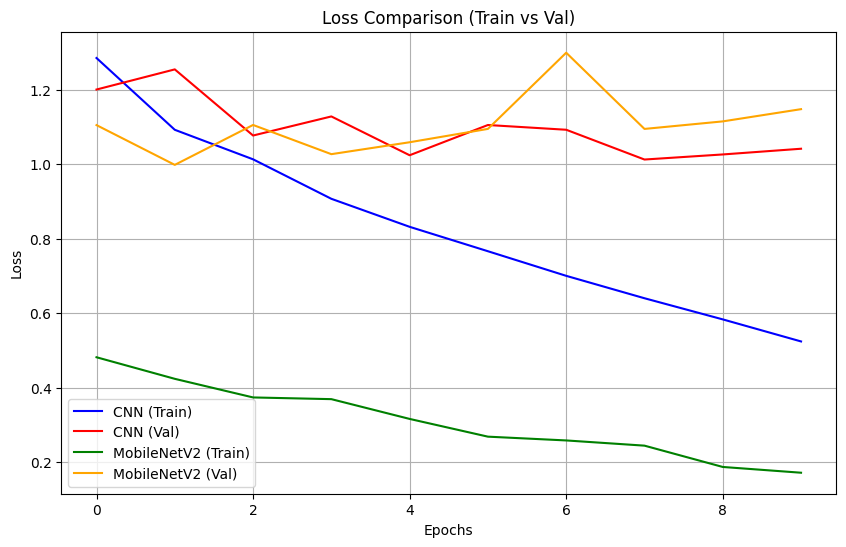

In [166]:
plt.figure(figsize=(10, 6))

plt.plot(train_loss_cnn, label='CNN (Train)', color='blue')
plt.plot(val_loss_cnn, label='CNN (Val)', color='red')

plt.plot(train_loss_MobileNetV2, label='MobileNetV2 (Train)', color='green')
plt.plot(val_loss_MobileNetV2, label='MobileNetV2 (Val)', color='orange')

plt.title('Loss Comparison (Train vs Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **4) Рекурентні нейронні мережі.Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами: а) навчить мережу і embedding шар з нуля (from scratch), б) використовуючи pretrained word embeddings.**

In [169]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('tapakah68/email-spam-classification', 'Email Spam Text Classification Dataset')

Dataset URL: https://www.kaggle.com/datasets/tapakah68/email-spam-classification


In [170]:
import zipfile
path_to_zip_file = '/content/Email Spam Text Classification Dataset/email-spam-classification.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as z:
    z.extractall('Email Spam Text Classification Dataset')

In [176]:
df = pd.read_csv('/content/Email Spam Text Classification Dataset/email_spam.csv')
df

,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam
...,...,...,...
79,Your application for the position of Child Pr...,"Dear Maryam, \n\n \n\nI would like to thank yo...",not spam
80,Your Kilimall Account is Ready - Shopping Now!,"Dear Customer,\n\nWelcome to Kilimall, Thanks ...",not spam
81,Your Steam account: Access from new web or mob...,"Dear vladis163rus,\nHere is the Steam Guard co...",not spam
82,Your uploaded document is rejected,View In Browser | Log in\n \n \n\nSkrill logo\...,not spam


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   84 non-null     object
 1   text    84 non-null     object
 2   type    84 non-null     object
dtypes: object(3)
memory usage: 2.1+ KB


In [178]:
df.isnull().sum()

,0
title,0
text,0
type,0


In [179]:
df.shape

(84, 3)

In [ ]:
df['type'] = df['type'].map({'not spam': 1, 'spam': 0})

In [184]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_text
0,"Hi James,\n\nHave you claim your complimentary...",hi james claim complimentary gift yet ive comp...
1,"\nalt_text\nCongratulations, you just earned\n...",alttext congratulations earned 500 completed f...
2,"Here's your GitHub launch code, @Mortyj420!\n ...",heres github launch code mortyj420 octocat sta...
3,"Hello,\n \nThank you for contacting the Virtua...",hello thank contacting virtual reward center v...
4,"Hey Prachanda Rawal,\n\nToday's newsletter is ...",hey prachanda rawal todays newsletter jampacke...
5,Model Casting Call\nThank you for taking the t...,model casting call thank taking time register ...
6,Model Casting Call\nThank you for taking the t...,model casting call thank taking time register ...
7,Today more than ever you need to upskill and r...,today ever need upskill reskill global job mar...
8,"\nLogo Image\nSenol Yildirim,\n\nSomeone signe...",logo image senol yildirim someone signedin acc...
9,"Hi,\n\n \n\nThank you for your interest in joi...",hi thank interest joining appen email official...


In [241]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, padding='post', maxlen=100)

In [242]:
y = to_categorical(df['type'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))

In [244]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [245]:
history_scratch = model.fit(X_train,
          y_train,
          epochs=50,
          batch_size=64,
          validation_data=(X_test, y_test))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 643ms/step - accuracy: 0.5050 - loss: 0.6945 - val_accuracy: 0.6471 - val_loss: 0.6790
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6968 - loss: 0.6498 - val_accuracy: 0.6471 - val_loss: 0.6776
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7125 - loss: 0.6243 - val_accuracy: 0.6471 - val_loss: 0.6838
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7020 - loss: 0.6185 - val_accuracy: 0.6471 - val_loss: 0.6791
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7172 - loss: 0.6202 - val_accuracy: 0.6471 - val_loss: 0.6763
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7224 - loss: 0.6018 - val_accuracy: 0.6471 - val_loss: 0.6743
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.7376 - loss: 0.6077 - val_accuracy: 0.6471 - val_loss: 0.6724
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.7475 - loss: 0.6193 - val_accuracy: 0.6471 - val_loss:

In [246]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8235 - loss: 0.6265
Accuracy: 0.8235


In [247]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,528 (8.83 MB)

 Trainable params: 771,842 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,543,686 (5.89 MB)

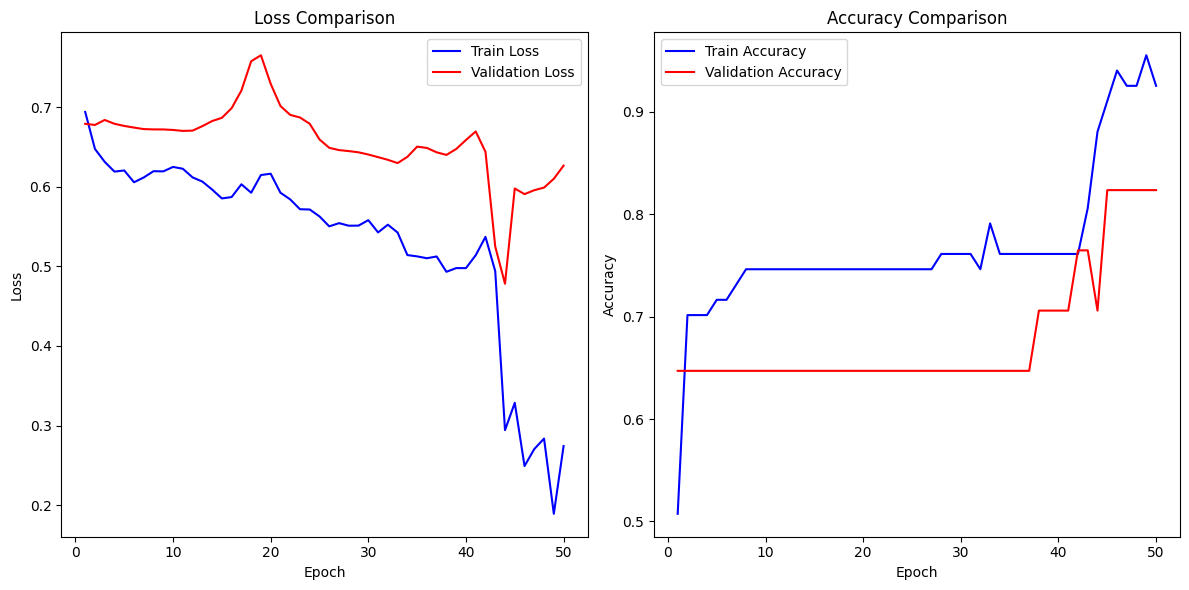

In [248]:
train_loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']
train_accuracy = history_scratch.history['accuracy']
val_accuracy = history_scratch.history['val_accuracy']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, 51), val_loss, label='Validation Loss', color='red')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracy, label='Train Accuracy', color='blue')
plt.plot(range(1, 51), val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [263]:
embedding_index = {}
with open('/content/drive/MyDrive/Data Analyzis/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((5000, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))  # Замораживаем веса
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_embeddings=model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - accuracy: 0.5557 - loss: 0.6982 - val_accuracy: 0.6471 - val_loss: 0.6505
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6968 - loss: 0.6562 - val_accuracy: 0.6471 - val_loss: 0.6479
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6968 - loss: 0.6419 - val_accuracy: 0.6471 - val_loss: 0.6438
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7072 - loss: 0.6242 - val_accuracy: 0.6471 - val_loss: 0.6322
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7072 - loss: 0.6025 - val_accuracy: 0.6471 - val_loss: 0.6033
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.7271 - loss: 0.6053 - val_accuracy: 0.6471 - val_loss: 0.5773
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7376 - loss: 0.5934 - val_accuracy: 0.7059 - val_loss: 0.5651
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.7423 - loss: 0.5990 - val_accuracy: 0.7647 - val_loss: 0.5580
Epo

In [265]:
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 852,520 (3.25 MB)

 Trainable params: 117,506 (459.01 KB)

 Non-trainable params: 500,000 (1.91 MB)

 Optimizer params: 235,014 (918.03 KB)

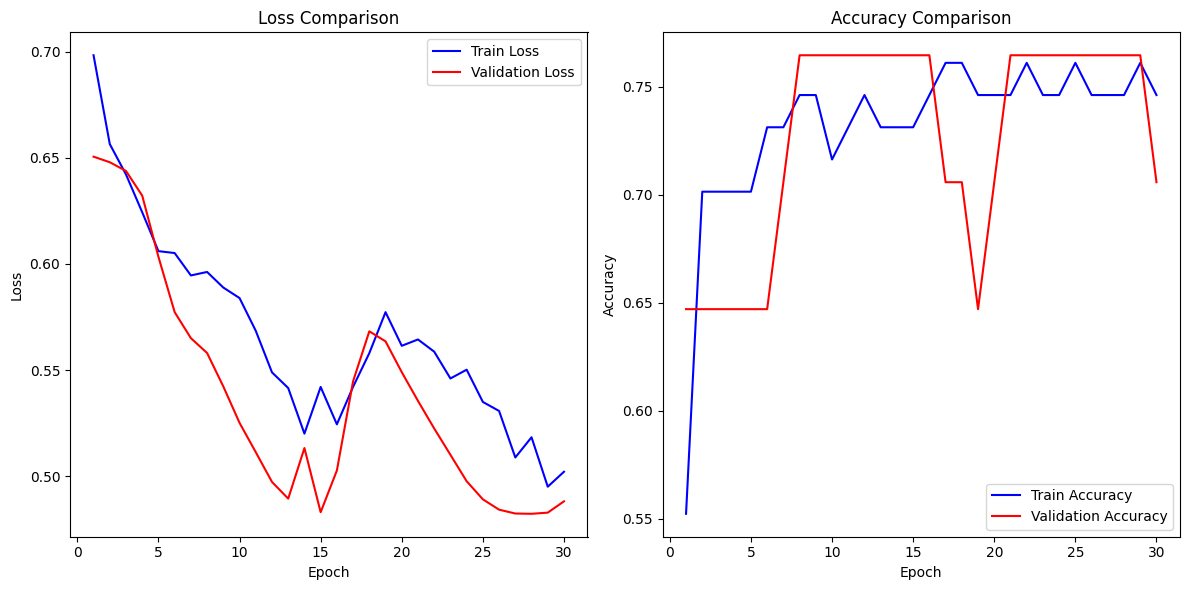

In [267]:
train_loss = history_embeddings.history['loss']
val_loss = history_embeddings.history['val_loss']
train_accuracy = history_embeddings.history['accuracy']
val_accuracy = history_embeddings.history['val_accuracy']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 31), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, 31), val_loss, label='Validation Loss', color='red')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, 31), train_accuracy, label='Train Accuracy', color='blue')
plt.plot(range(1, 31), val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

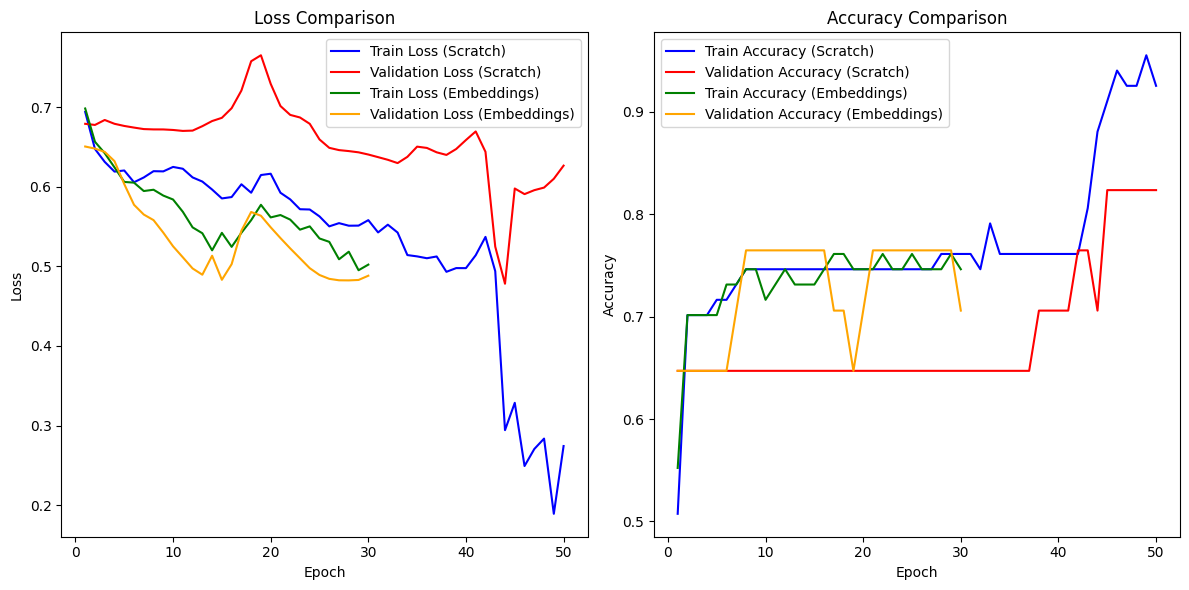

In [268]:
train_loss_scratch = history_scratch.history['loss']
val_loss_scratch = history_scratch.history['val_loss']
train_accuracy_scratch = history_scratch.history['accuracy']
val_accuracy_scratch = history_scratch.history['val_accuracy']

train_loss_embeddings = history_embeddings.history['loss']
val_loss_embeddings = history_embeddings.history['val_loss']
train_accuracy_embeddings = history_embeddings.history['accuracy']
val_accuracy_embeddings = history_embeddings.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_scratch) + 1), train_loss_scratch, label='Train Loss (Scratch)', color='blue')
plt.plot(range(1, len(val_loss_scratch) + 1), val_loss_scratch, label='Validation Loss (Scratch)', color='red')
plt.plot(range(1, len(train_loss_embeddings) + 1), train_loss_embeddings, label='Train Loss (Embeddings)', color='green')
plt.plot(range(1, len(val_loss_embeddings) + 1), val_loss_embeddings, label='Validation Loss (Embeddings)', color='orange')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy_scratch) + 1), train_accuracy_scratch, label='Train Accuracy (Scratch)', color='blue')
plt.plot(range(1, len(val_accuracy_scratch) + 1), val_accuracy_scratch, label='Validation Accuracy (Scratch)', color='red')
plt.plot(range(1, len(train_accuracy_embeddings) + 1), train_accuracy_embeddings, label='Train Accuracy (Embeddings)', color='green')
plt.plot(range(1, len(val_accuracy_embeddings) + 1), val_accuracy_embeddings, label='Validation Accuracy (Embeddings)', color='orange')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()